In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


df = pd.read_csv("/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv", sep=";", low_memory=False)
df.columns
df_idf = df[df['Région'] == 'Île-de-France'].copy()
# Charger le fichier CSV contenant les données, en spécifiant le séparateur et désactivant l'option low_memory
# Remplacer les valeurs manquantes par 0

df['Consommation (MW)'] = df['Consommation (MW)'].fillna(0)
df['Thermique (MW)'] = df['Thermique (MW)'].fillna(0)
df['Nucléaire (MW)'] = df['Nucléaire (MW)'].fillna(0)

# Convertir la colonne de production éolienne en numérique, remplacer les erreurs par NaN puis par
df['Eolien (MW)'] = pd.to_numeric(df['Eolien (MW)'], errors='coerce').fillna(0)
df['Solaire (MW)'] = df['Solaire (MW)'].fillna(0)
df['Hydraulique (MW)'] = df['Hydraulique (MW)'].fillna(0)
df['Pompage (MW)'] = df['Pompage (MW)'].fillna(0)
df['Bioénergies (MW)'] = df['Bioénergies (MW)'].fillna(0)
df = df.drop('Column 30', axis=1)

# Remplacement des valeurs NaN par 0 dans les colonnes TCO
colonnes_tco = ["TCO Thermique (%)", "TCO Nucléaire (%)", "TCO Eolien (%)",
                "TCO Hydraulique (%)", "TCO Solaire (%)", "TCO Bioénergies (%)"]
df[colonnes_tco] = df[colonnes_tco].fillna(0)


# Garder uniquement les lignes où au moins une valeur TCO est non nulle
df = df[(df[colonnes_tco] != 0).any(axis=1)]

# Remplacement des valeurs NaN par 0 dans les colonnes TCH
colonnes_tch = ["TCH Thermique (%)", "TCH Nucléaire (%)", "TCH Eolien (%)",
                "TCH Hydraulique (%)", "TCH Solaire (%)", "TCH Bioénergies (%)"]
df[colonnes_tch] = df[colonnes_tch].fillna(0)


# Garder uniquement les lignes où au moins une valeur TCH est non nulle
df = df[(df[colonnes_tch] != 0).any(axis=1)]

# Regrouper les données par région et calculer la consommation totale d'électricité pour chaque région
consumption_by_region = df.groupby('Région')['Consommation (MW)'].sum().sort_values(ascending=False)
df.head()

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,TCO Nucléaire (%),TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%)
1472256,24,Centre-Val de Loire,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,2965.0,105.0,8013.0,18.0,...,270.25,68.90,0.61,1.42,0.0,0.0,1.65,52.69,2.09,48.44
1472257,11,Île-de-France,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,10462.0,326.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,1.28,39.88
1472258,27,Bourgogne-Franche-Comté,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,2737.0,181.0,0.0,247.0,...,0.00,0.00,9.02,30.12,0.0,0.0,4.53,23.62,1.75,50.00
1472259,52,Pays de la Loire,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,4078.0,359.0,0.0,135.0,...,0.00,0.00,3.31,13.34,0.0,0.0,0.12,50.00,1.32,47.79
1472260,32,Hauts-de-France,Données définitives,2020-01-01,00:00,2019-12-31T23:00:00+00:00,6582.0,2030.0,4507.0,1575.0,...,68.47,82.55,23.93,34.19,0.0,0.0,0.03,50.00,1.81,51.97


Taille des données après suppression des NaN pour Île-de-France: (36527, 35)
Consommation (MW):
MSE: 47179.94487798457
RMSE: 217.2094493294078
R²: 0.9888046595598009

Production (MW):
MSE: 2968.758365310978
RMSE: 54.486313559562625
R²: 0.9629155958135875


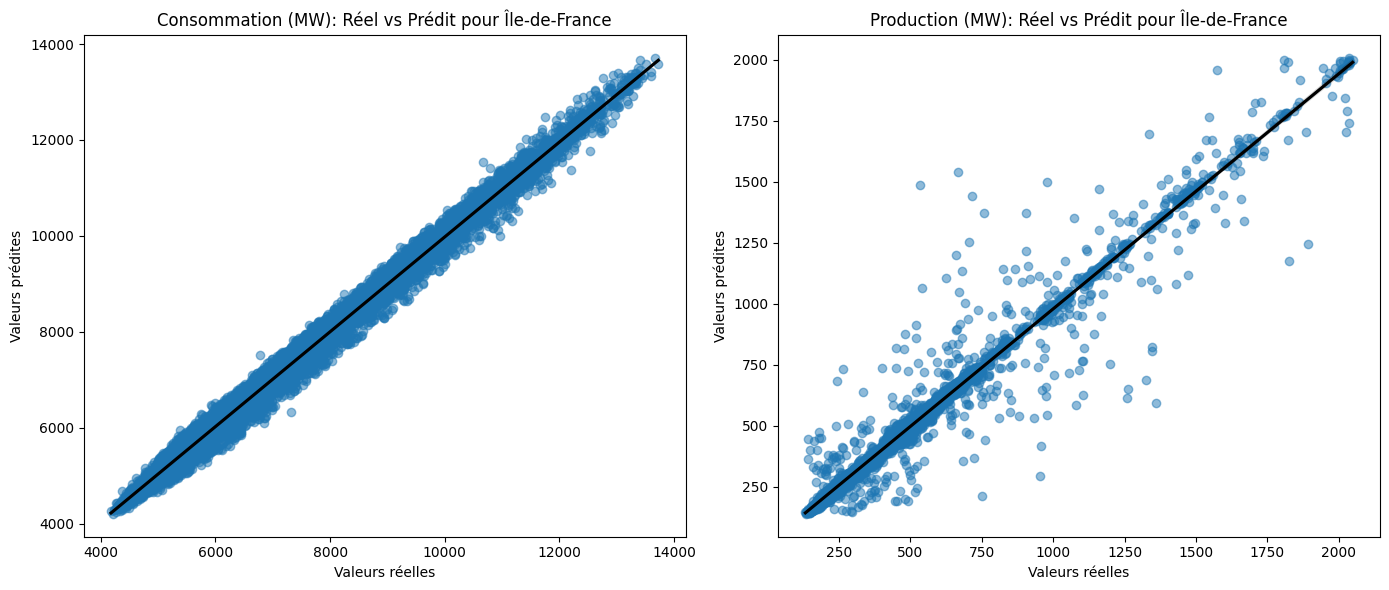

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Chargement des données
df = pd.read_csv(
    "/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv",
    sep=";",
    low_memory=False
)

# Vérification que toutes les colonnes nécessaires existent
required_columns = [
    'Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
    'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)', 'Consommation (MW)', 'Région'
]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Colonnes manquantes: {missing_columns}")

# Filtrage pour "Île-de-France"
df_idf = df[df['Région'] == 'Île-de-France'].copy()

# Conversion des valeurs d'éolien en numériques
df_idf['Eolien (MW)'] = pd.to_numeric(df_idf['Eolien (MW)'], errors='coerce')

# Gestion des valeurs manquantes
df_idf['Eolien (MW)'] = df_idf['Eolien (MW)'].ffill().fillna(0)

# Calcul de la production totale d'électricité
df_idf['Production (MW)'] = (
    df_idf['Thermique (MW)'] +
    df_idf['Nucléaire (MW)'] +
    df_idf['Eolien (MW)'] +
    df_idf['Solaire (MW)'] +
    df_idf['Hydraulique (MW)'] +
    df_idf['Pompage (MW)'] +
    df_idf['Bioénergies (MW)']
)

# Création des caractéristiques (features)
df_idf['Consommation_N-1'] = df_idf['Consommation (MW)'].shift(1)
df_idf['Production_N-1'] = df_idf['Production (MW)'].shift(1)

# Suppression des lignes contenant des NaN
df_idf = df_idf.dropna(subset=['Consommation_N-1', 'Production_N-1', 'Consommation (MW)', 'Production (MW)'])

# Vérification des dimensions
print(f"Taille des données après suppression des NaN pour Île-de-France: {df_idf.shape}")

# Variables X et y
X = df_idf[['Consommation_N-1', 'Production_N-1']]
y = df_idf[['Consommation (MW)', 'Production (MW)']]

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Découpage en ensembles d'entraînement et de test
train_size = int(0.8 * len(df_idf))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Calcul des métriques pour Consommation (MW)
mse_conso = mean_squared_error(y_test['Consommation (MW)'], y_pred[:, 0])
rmse_conso = np.sqrt(mse_conso)
r2_conso = r2_score(y_test['Consommation (MW)'], y_pred[:, 0])

# Calcul des métriques pour Production (MW)
mse_prod = mean_squared_error(y_test['Production (MW)'], y_pred[:, 1])
rmse_prod = np.sqrt(mse_prod)
r2_prod = r2_score(y_test['Production (MW)'], y_pred[:, 1])

# Affichage des métriques
print("Consommation (MW):")
print(f"MSE: {mse_conso}")
print(f"RMSE: {rmse_conso}")
print(f"R²: {r2_conso}")

print("\nProduction (MW):")
print(f"MSE: {mse_prod}")
print(f"RMSE: {rmse_prod}")
print(f"R²: {r2_prod}")

# Graphiques des valeurs réelles vs prédites
plt.figure(figsize=(14, 6))

# Consommation (MW)
plt.subplot(1, 2, 1)
sns.regplot(x=y_test['Consommation (MW)'], y=y_pred[:, 0], scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'})
plt.title('Consommation (MW): Réel vs Prédit pour Île-de-France')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')

# Production (MW)
plt.subplot(1, 2, 2)
sns.regplot(x=y_test['Production (MW)'], y=y_pred[:, 1], scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'})
plt.title('Production (MW): Réel vs Prédit pour Île-de-France')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')

plt.tight_layout()
plt.show()

<ipython-input-15-16015ffae271>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Consommation (MW)'] = y


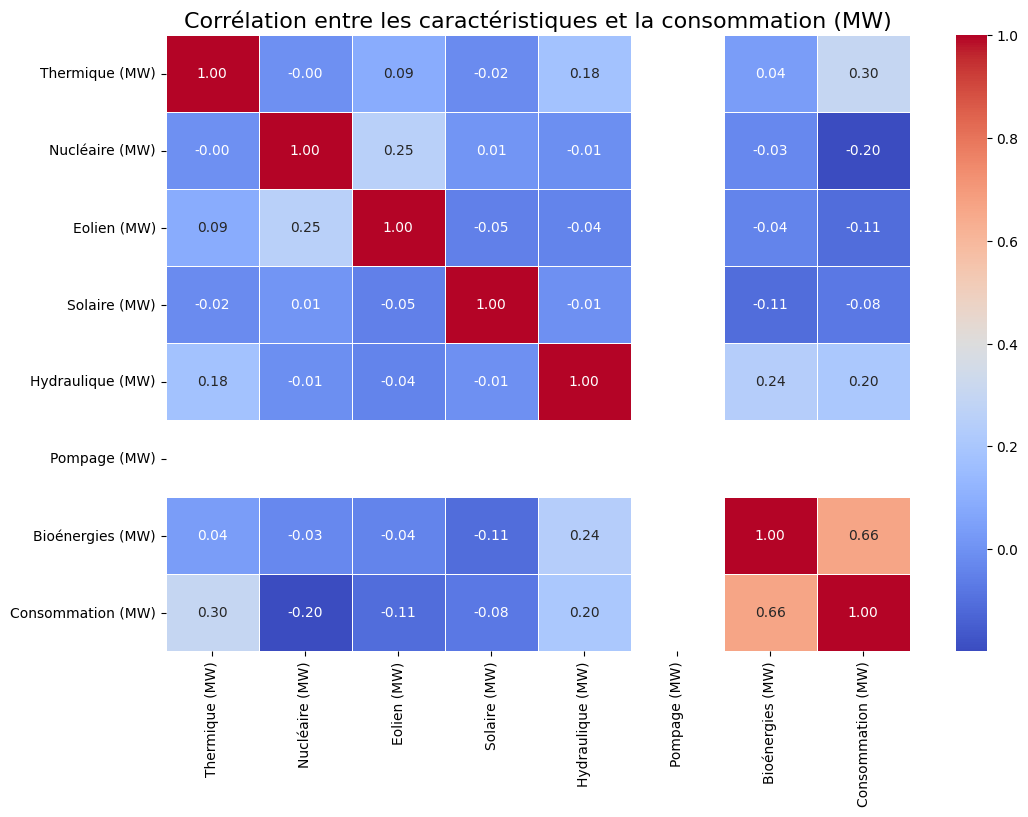

Linear Regression - Validation croisée (RMSE moyen) : 1212.3349951021476
Ridge Regression - Validation croisée (RMSE moyen) : 1212.3349951021426
Lasso Regression - Validation croisée (RMSE moyen) : 1212.3349951234609
Decision Tree Regressor - Validation croisée (RMSE moyen) : 746.4211629880956
Random Forest Regressor - Validation croisée (RMSE moyen) : 580.8182718362082


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear Regression:
  RMSE: 1213.104233950885
  MSE: 1471621.8824295632
  MAE: 923.8636675426382
  R²: 0.552939767738506
--------------------------------------------------


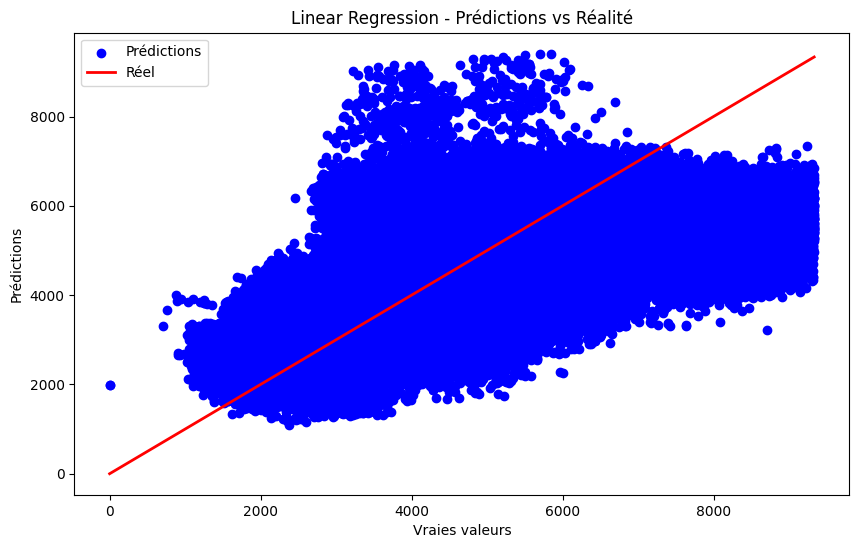

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge Regression:
  RMSE: 1213.1042339522962
  MSE: 1471621.8824329872
  MAE: 923.8636675563697
  R²: 0.5529397677374659
--------------------------------------------------


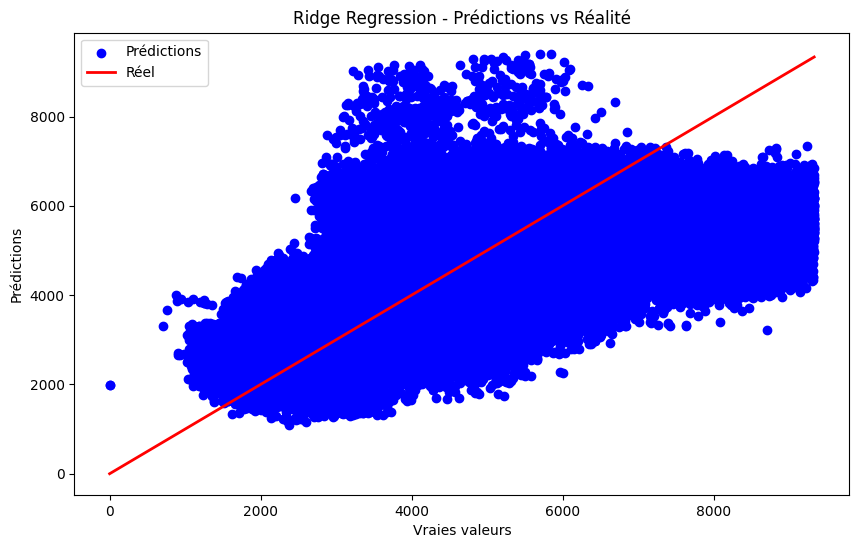

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Lasso Regression:
  RMSE: 1213.1042458882089
  MSE: 1471621.911392
  MAE: 923.8637397259915
  R²: 0.5529397589400817
--------------------------------------------------


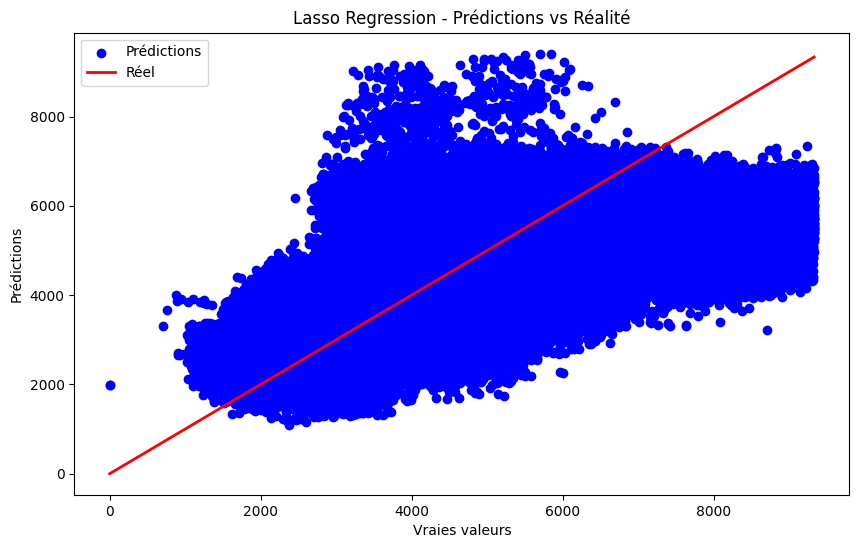

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Decision Tree Regressor:
  RMSE: 741.0899421401261
  MSE: 549214.3023412555
  MAE: 550.3687169059865
  R²: 0.833155597577377
--------------------------------------------------


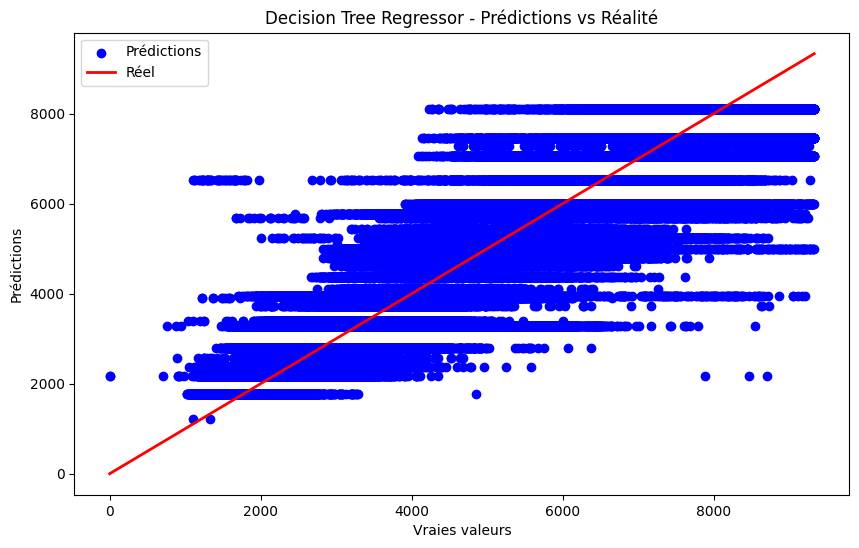

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest Regressor:
  RMSE: 578.4173714477859
  MSE: 334566.6555925659
  MAE: 428.0343600846441
  R²: 0.8983628549276327
--------------------------------------------------


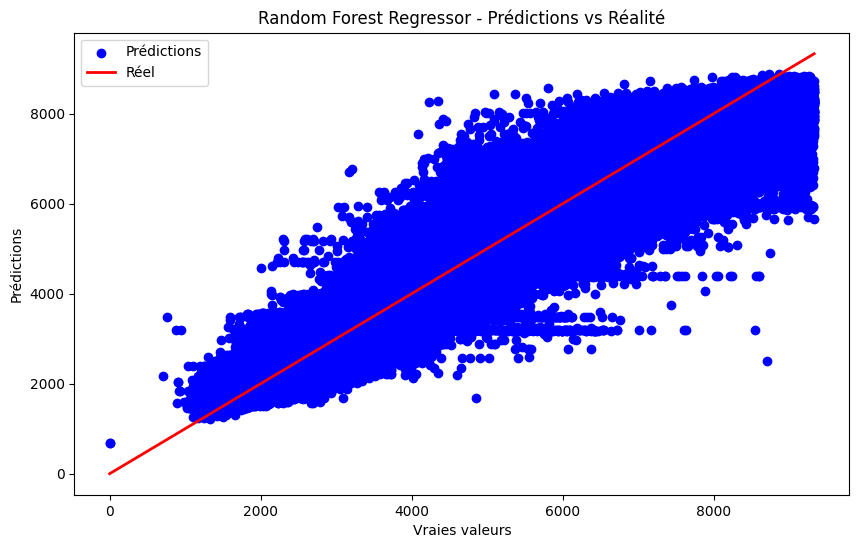

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import seaborn as sns

# Chargement des données
df = pd.read_csv(
    "/content/drive/MyDrive/groupeDeTravail-BDAenergie/eco2mix-regional-cons-defcopiecopy.csv",
    sep=";", low_memory=False
)

# Prétraitement des données
df['Consommation (MW)'] = df['Consommation (MW)'].fillna(0)
df['Thermique (MW)'] = df['Thermique (MW)'].fillna(0)
df['Nucléaire (MW)'] = df['Nucléaire (MW)'].fillna(0)

# Convertir les colonnes en numériques et gérer les erreurs
colonnes_energie = ['Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)']
for col in colonnes_energie:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Supprimer les colonnes inutiles si elles existent
if 'Column 30' in df.columns:
    df = df.drop('Column 30', axis=1)

# Détection des outliers avec les Z-scores
z_scores = np.abs(zscore(df[[
    'Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
    'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)'
]]))
threshold = 3
outliers = np.where(z_scores > threshold)
df_cleaned = df.drop(outliers[0])

# Filtrer les lignes où au moins une valeur TCO est non nulle
df_cleaned = df_cleaned[(df_cleaned[colonnes_tco] != 0).any(axis=1)]

# Suppression des outliers avec IQR
Q1 = df_cleaned[colonnes_energie + ['Consommation (MW)']].quantile(0.25)
Q3 = df_cleaned[colonnes_energie + ['Consommation (MW)']].quantile(0.75)
IQR = Q3 - Q1
condition = ~((df_cleaned[colonnes_energie + ['Consommation (MW)']] < (Q1 - 1.5 * IQR)) |
              (df_cleaned[colonnes_energie + ['Consommation (MW)']] > (Q3 + 1.5 * IQR))).any(axis=1)
df_cleaned = df_cleaned[condition]

# Sélection des colonnes pour X (caractéristiques) et y (cible)
X = df_cleaned[[
    'Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
    'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)'
]]
y = df_cleaned['Consommation (MW)']

# Ajout de y dans X pour pouvoir calculer la corrélation
X['Consommation (MW)'] = y

# Calcul de la matrice de corrélation
corr_matrix = X.corr()

# Visualisation de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Corrélation entre les caractéristiques et la consommation (MW)', fontsize=16)
plt.show()

# Division en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Consommation (MW)']), y, test_size=0.2, random_state=42)

# Modèles à tester
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=0, max_depth=5),
    'Random Forest Regressor': RandomForestRegressor(random_state=0, n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2),
}

# Validation croisée pour chaque modèle
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f'{model_name} - Validation croisée (RMSE moyen) : {np.mean(np.sqrt(-cv_scores))}')

# Entraînement, prédictions et évaluation des performances
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'{model_name}:')
    print(f'  RMSE: {rmse}')
    print(f'  MSE: {mse}')
    print(f'  MAE: {mae}')
    print(f'  R²: {r2}')
    print('-' * 50)

    # Visualisation des prédictions vs vraies valeurs
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Prédictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Réel')
    plt.xlabel('Vraies valeurs')
    plt.ylabel('Prédictions')
    plt.title(f'{model_name} - Prédictions vs Réalité')
    plt.legend()
    plt.show()
